# A first look at data

date: 12/04/2018

Example code for reading and checking data


In [ ]:
import pandas as pd
import dask.dataframe as dd
import glob as glob
import numpy as np
from scipy.stats import kde

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.colors import LogNorm
plt.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

This is the part that reads data and makes a basic selection

In [ ]:
df = pd.DataFrame()
df = pd.read_hdf('/data/IceCube/merged2015.h5', key='data')
df['cos2'] = np.cos(df.zenith)**2
df['I'] = 0
df.drop(df.columns.difference(['s125',"cos2", "I"]), 1, inplace= True)
df= df.loc[df.s125>25]
df= df.loc[df.cos2>0.5]  
print(df.count())
#df.drop(["Run", "Event"], 1, inplace = True)


In [ ]:
#hist = plt.hist(np.degrees(df.zenith), bins=150)

hist= plt.hist(np.log10(df.s125),bins= 200)

In [ ]:

import os
filepath='/home/ioana/src/icecube/Noemi/stage/cic_att' 
os.chdir(filepath)
%run data_functions.py
from data_functions import set_intensity
bins = 10
df.reset_index(inplace=True)
df, group = set_intensity(df, bins)


In [ ]:
%run data_functions.py
from data_functions import get_data_to_fit
#plt.plot(np.log10(df.s125),np.log10(df.I), 'ro')
df['s125_error'] = 0.1*df['s125']
vals, s125_fit, bin_centers, s125_fit_error  = get_data_to_fit(df, intensity= 300, n_bins = bins)
print(vals)
plt.errorbar(bin_centers, s125_fit, yerr=s125_fit_error, fmt=".k")
#plt.plot(bin_centers, s125_fit, 'ro')

In [ ]:
fit_vals, cov = get_attenuation_parameters(s125_fit, bin_centers)
fig2, ax2 =plt.subplots(figsize=(10,6))
plt.grid()
from data_functions import get_s125 
print(fit_vals)
a1=fit_vals[0]
a2=fit_vals[1]
a3=fit_vals[2]
y=get_s125(bin_centers, a1,a2,a3)
#y2=get_s125(bins, alpha, beta, a3)

ax2.plot(bin_centers, s125_fit, lw=0, marker='o')
ax2.plot(bin_centers, y, color="r")
#ax2.plot(bins2,y2)

In [ ]:
def compute_bootsrap_uncertainties(data, samples, bins, intenstity):
    for i in range(samples):
        rand_data = get_bootstrap_data(data)
        rand_data, groups = set_intensity(rand_data, bins)
        print(i)
compute_bootsrap_uncertainties(df, 2, bins, 100)

0.9149076709228637
8
0.8482812371800189
7
0.9923744855708777
9
0.8099568326188297
6
0.735317568462187
5
0.7093823362153255
4
0.6663951719691276
3
0.5597169685858354
2
0.5419221023735766
1
        index        s125      cos2    I  s125_error
36065    9116  119.276033  0.916676  300   11.927603
1284   117390  118.559899  0.861126  300   11.855990
30782   64929  116.521550  0.972225  300   11.652155
11770  142575  111.615775  0.805577  300   11.161577
18098   96716  108.523853  0.750027  300   10.852385
31251   44541  103.394314  0.694478  300   10.339431
13935  147532   92.574739  0.638928  300    9.257474
31602  161543   83.547529  0.583379  300    8.354753
34972   99879   70.435330  0.527829  300    7.043533


/data/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<Container object of 3 artists>

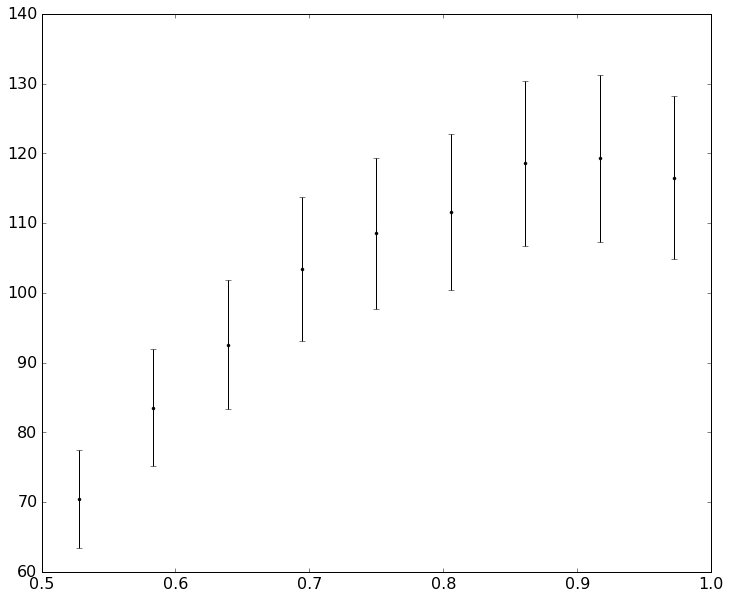

In [64]:
from tqdm import tqdm
%run data_functions.py
tqdm.pandas(desc="my bar!")
# Define cosine squared bins
data = df.copy()    
min_cos2 = data.cos2.min()
cos2_bins = np.linspace(min_cos2, 1, 10, endpoint=True)

# sort data by S125 values
data.sort_values(['s125'], ascending = False, inplace = True)

# Bin and group by cosine ^ 2
ind = np.digitize(data['cos2'], cos2_bins)
groups = data.groupby(ind)
for name, group in groups:
    initial_ind = group.I.index.tolist()
    test = group.copy()
    test.sort_values(['s125'], ascending= False, inplace = True)
    test.reset_index(inplace=True)
    test.drop(['index', 'level_0'], axis= 1, inplace=True)
    #print(test)
    data.loc[initial_ind, 'I'] = test.index.tolist()
#print(data)
data['s125_error'] = 0.1*data['s125']
vals  = get_data_to_fit(data, intensity= 300, n_bins = bins)
print(vals)
plt.errorbar(vals['cos2'].tolist(), vals['s125'].tolist(), yerr=vals['s125_error'].tolist(), fmt=".k")    

In [ ]:
%run data_functions.py

from data_functions import get_attenuation_parameters2

params_scipy, cov2 = sp.optimize.curve_fit(get_s125, bin_centers, s125_fit)
# Use as guess
a_true = params_scipy[0]
b_true = params_scipy[1]
f_true = params_scipy[2]
print (a_true, b_true, f_true)
#final_parameters, cov2, sample = get_attenuation_parameters2(s125_fit, s38_fit, s125_fit_error, bins, performMCMC=True)
sample = get_attenuation_parameters2(params_scipy, s125_fit, s125_fit_error, bin_centers)

In [ ]:
import math
cos_ref = np.cos(math.radians(38))**2
cos2 = bin_centers - cos_ref
print(len(sample))
# Plot a subset of the samples
for a, b, f in sample[np.random.randint(len(sample), size=200)]:
    plt.plot(cos2, f * (b * cos2**2 + a * cos2 + 1), color="k", alpha=0.1)
    plt.plot(cos2, f_true * (b_true * cos2**2 + a_true * cos2 + 1), color="r", lw=2, alpha=0.8)
    plt.errorbar(bin_centers-cos_ref, s125_fit, yerr=s125_fit_error, fmt=".k")

In [ ]:
import corner
fig = corner.corner(sample, labels=["$a$","$b$", "$s38$"])
fig.savefig("")

In [ ]:
filenames = glob.glob('/data/IceCube/2015/*')
number_of_files = 10000
store = merge_and_select_data(filenames, '/data/IceCube/merged2015.h5', number_of_files )        
dataAll = pd.DataFrame() 
dataAll = store.select('data')
print(dataAll.count())
store.close()    


